In [3]:
# import what you need ! 

import sys
sys.path.append('../2_modules/')

import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import pandas as pd
import subprocess as sp
from subprocess import Popen

# our modules: 
import notepicker
import makeDataChord as mDc
import writeCmixSco_GRAN_v2 as wRT_gran
import writeCmixSco_WT_ac as wRT_wt
# _ac stands for autocheck

%matplotlib inline

# ======================================================
# autocheck for your RTcmix installation type: 
cmixStatus, cmixResult = sp.getstatusoutput("CMIX")
if cmixStatus == 0:
    cmixInstalled = True
    print("CMIX found.")
else:
    cmixInstalled = False
    print("CMIX not found, using pyGoRTcmix instead.")
# ======================================================

%matplotlib inline

CMIX found.


# ================================================
## READ IN THE DATA ! 

In [52]:
# READ IN THE DATA FILE ! ! !
datafilename = '../0_data_examples/breathalyzer/BA_ben_1.pkl'
breath = pd.read_pickle(datafilename) # np.loadtxt(datafilename)
print(breath[0:5])
time = np.array(breath.time_s)
p1 = temp_C = np.array(breath.temp_C)
p2 = humidity = np.array(breath.hum)

# put the data into a dictionary: 
# (very useful, but we will also work with pandas)
data_dict = {}
data_dict['time_o'] = time  # the _o indicates these are the original values, un-re-sampled
data_dict['p1_o'] = p1

      hum  temp_C  time_s
0  46.151   20.89  0.0000
1  46.088   20.90  0.3492
2  46.025   20.90  0.7246
3  45.995   20.92  1.0998
4  45.965   20.93  1.4751


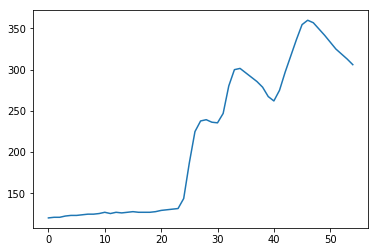

In [61]:
# PITCH 
# using RTcmix octave notation! octpch: http://rtcmix.org/reference/scorefile/octpch.php
# n_octaves = 1
# octr = 0.08
# intervals = np.interp(p1,[min(p1),max(p1)],[0,n_octaves*octr])
# root_oct = 8.00 # middle C
# root_note = 0.00
# #p1_scl = rootp1*scale + shift
# p1_scl = root_oct + root_note + intervals
# plt.plot(p1_scl)

# using frequency values (any value larger than 20.0 ?)
root_freq = 8.00
peak_freq = 10.08
p1_scl = np.interp(p1,[min(p1),max(p1)],[root_freq,peak_freq])

plt.plot(p1_scl)

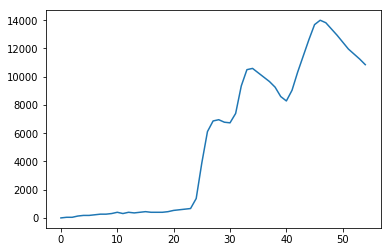

In [62]:
# AMPLITUDE
amp_range = [0,14000]
amp = np.interp(p1,[min(p1),max(p1)],amp_range)
plt.plot(amp)

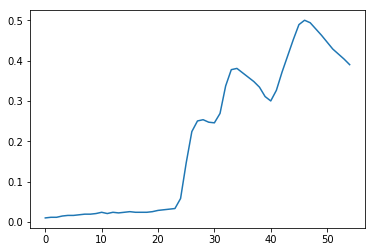

In [63]:
# PITCHJITTER

# p13 ("PITCHJITTER") sets the maximum randomly determined amount to add or subtract from the current pitch (in linear octaves).

pitchjtr_range = [0.01,0.5]
pitchjtr = np.interp(p1,[min(p1),max(p1)],pitchjtr_range)
plt.plot(pitchjtr)

# =============================================
## 2) Granular Synthesis ! 

In [64]:
#create RTcmix score
reload(wRT_gran)

tones_dict = {}
#cmixInstalled variable can also be passed to the writeCmixSco module directly from the notebook
tones_dict['cmixInstalled'] = cmixInstalled
tones_dict['base_name'] = 'lern_GRANSYNTH_v1_pitchjitVAR'
tones_dict['dur_sound'] = 16

# time series: 
tones_dict['p1'] = p1_scl
tones_dict['amplitude'] = amp # = np.array([7000])
# add pitchjitter
tones_dict['pitchjitter'] = pitchjtr # np.array([2.0]) # 

# single, constant values
#tones_dict['pitchjitter'] = 2.0 
tones_dict['hopjitter'] = 0.0

wRT_gran.writeCmixSco_GRAN(tones_dict)

dur = 16

55
Amplitude is time varying (p-field)
55
Pitchjitter is time varying (p-field)
CMIX found.
rtoutput("lern_GRANSYNTH_v1_pitchjitVAR.wav")

RTcmix score created.


In [65]:
#play RTcmix score and create a wave file
from subprocess import Popen
import subprocess as sp
import os

#use CMIX if installed; if not, use pyGoRTcmix
if cmixInstalled:
    cmix_cmd = 'CMIX < ' + tones_dict['base_name'] + '.sco'
else:
    cmix_duration = str(tones_dict['dur_sound'])
    cmix_cmd = '../pyGoRTcmix/pyGoRTcmix -inputscore ' + os.path.abspath(tones_dict['base_name'] + '.sco ') + '-output ' + os.path.abspath(tones_dict['base_name'] + '.wav ') +'-dur ' + cmix_duration
print(cmix_cmd)

# NOTE if the file exists already, you *MAY* have to delete it by hand to make a new one. 
# best way is to use sp to check if it is exists, and if so, delete it.

runCMIX = sp.Popen(cmix_cmd, shell=True) # if can only be called from a shell, use shell=True

runCMIX.wait()
print('\nhopefully i just wrote your sound file (' + tones_dict['base_name'] + '.wav); is it here?')
! ls *.wav


CMIX < lern_GRANSYNTH_v1_pitchjitVAR.sco

hopefully i just wrote your sound file (lern_GRANSYNTH_v1_pitchjitVAR.wav); is it here?
lern_GRANSYNTH_v1_pitchjitVAR.wav


## ------------------------------------------------------------
## Plot the spectrogram to see effects of GranSynth parameters

0.6.2


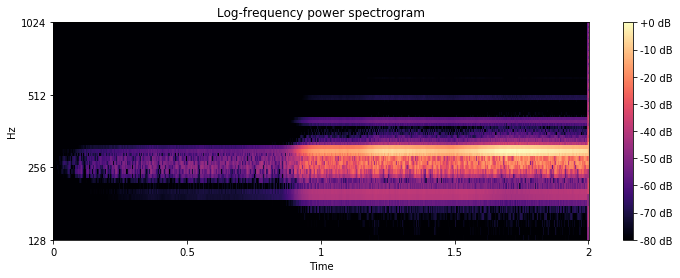

In [58]:
# LOAD THE SOUND FILE
import librosa
print(librosa.__version__)
import librosa.display

filename = tones_dict['base_name'] + '.wav'

y, sr = librosa.load(filename)
y_db = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max) 

plt.figure(figsize=(12,4))
librosa.display.specshow(y_db, sr=sr, hop_length=64, x_axis='time', y_axis='log') #y_axis='log'
plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency power spectrogram')
plt.ylim([128,1024])

figname = tones_dict['base_name'] + '.png'
plt.savefig(figname,dpi=120)

Text(0,0.5,'dB')

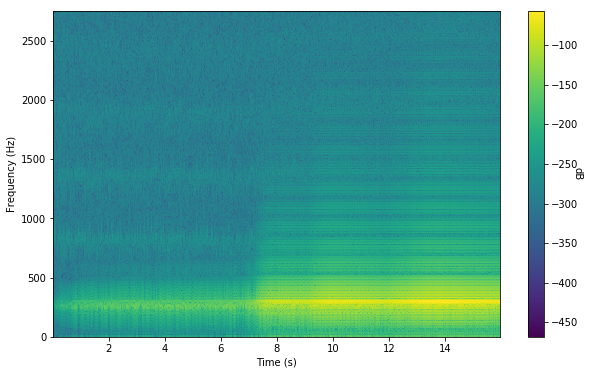

In [59]:
# Or a lower level approach, using scipy, spsig. 

from scipy import signal as spsig

# Compute the spectrogram
NfftSTFT = 4096 # The number of frequency points for the FFT of each frame
SliceLength = int(0.05*sr) # The length of each frame (should be expressed in samples)
Overlap = int(SliceLength/4) # The overlapping between successive frames (should be expressed in samples)
[fSTFT, tSTFT, STFT] = spsig.spectrogram(y, fs=sr, nperseg=SliceLength, noverlap=Overlap, nfft=NfftSTFT) 
# also provides associated f and t vectors!

# Plot the spectrogram
plt.figure(figsize=(10,6))
plt.pcolormesh(tSTFT,fSTFT,20*np.log10(np.absolute(STFT)))
plt.ylim([0,sr/8])
#plt.xlim([0,dur1-SliceLength/sr])
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
cbar = plt.colorbar()
cbar.ax.set_ylabel('dB', rotation=270)

In [60]:
sp.run(['mv', tones_dict['base_name'], '../3_output_nogit'])
sp.run('mv *.wav ../3_output_nogit/', shell=True)

CompletedProcess(args='mv *.wav ../3_output_nogit/', returncode=0)